In [1]:
import sys; sys.path.append('../../src/playground_jax')
from time import time

from jax import numpy as jnp, random, tree_util
from jax import grad, value_and_grad, vmap, jit
import optax
import matplotlib.pyplot as plt

from models import *

Goal: fit a scalar real-valued funciton
$ f: D \subset \mathbb{R} \rightarrow \mathbb{R}$

1. Generate training data

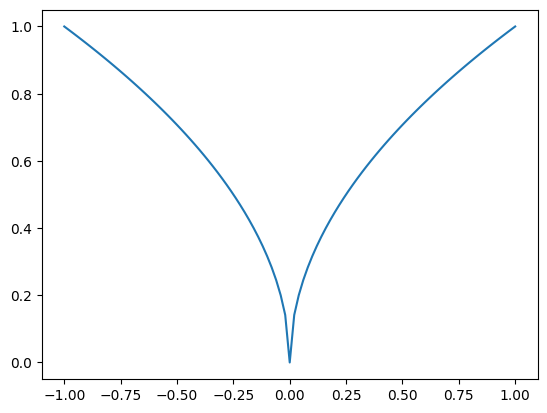

In [2]:
N = 101
x = jnp.expand_dims(jnp.linspace(-1, 1, N), axis=-1)
y = jnp.sqrt(jnp.abs(x))
#y = x**2
fig, ax = plt.subplots()
ax.plot(x, y)
plt.show()

2. build a model

In [3]:
# set a random key
key = random.PRNGKey(1)

params = init_mlp_params([1, 32, 32, 1])

In [4]:
tree_util.tree_map(lambda x: x.shape, params)

[{'biases': (32,), 'weights': (1, 32)},
 {'biases': (32,), 'weights': (32, 32)},
 {'biases': (1,), 'weights': (32, 1)}]

3. Define loss (mean square error loss)

In [5]:
def loss_fn(params, x, y):
    pred_y = vmap(forward, in_axes=(None, 0), out_axes=0)(params, x)
    return jnp.mean((y - pred_y) ** 2)

4. choose optimizer

In [6]:
lr = 1e-3
opt = optax.adam(learning_rate=lr)
opt_state = opt.init(params)
#print(opt_state)

5. Update function

In [7]:
@jit
def update_fn(params, opt_state, x, y):
    loss, grads = value_and_grad(loss_fn)(params, x, y)

    # manula sgd update
    #params = jax.tree_map(lambda p, g: p - lr * g, params, grads)

    # optimizer update
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return loss, params, opt_state

6. Train

In [8]:
n_iter = int(1e4)
log_period_iter = int(1e3)
for i in range(n_iter):
    t0 = time()
    loss, params, opt_state = update_fn(params, opt_state, x, y)
    t1 = time()
    if i % log_period_iter == 0: 
        print('it: {:d}, loss: {:.3e}, time: {:.4f}s'.format(i, loss, t1-t0))

it: 0, loss: 3.834e+00, time: 0.1626s
it: 1000, loss: 7.524e-04, time: 0.0000s
it: 2000, loss: 5.060e-04, time: 0.0000s
it: 3000, loss: 3.909e-04, time: 0.0000s
it: 4000, loss: 3.384e-04, time: 0.0000s
it: 5000, loss: 2.954e-04, time: 0.0000s
it: 6000, loss: 2.508e-04, time: 0.0000s
it: 7000, loss: 2.031e-04, time: 0.0000s
it: 8000, loss: 1.692e-04, time: 0.0000s
it: 9000, loss: 1.689e-04, time: 0.0000s


7. Evaluate results

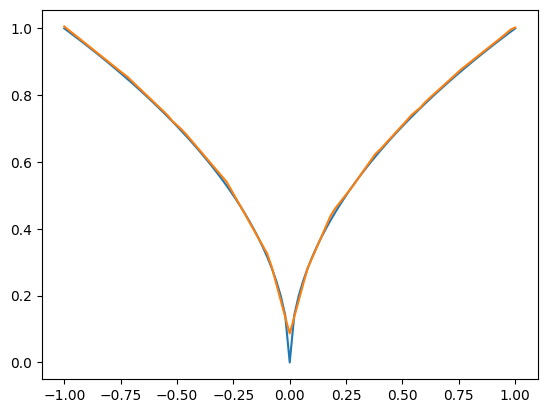

In [9]:
y_pred = vmap(forward, in_axes=(None, 0), out_axes=0)(params, x)
fig, ax = plt.subplots()
ax.plot(x, y)
ax.plot(x, y_pred)
plt.show()